In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv("Creditcard_data.csv")
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data['Class'].value_counts()


,count
Class,
0,763
1,9


In [4]:
df_majority = data[data.Class == 0]
df_minority = data[data.Class == 1]

df_majority_downsampled = df_majority.sample(
    n=len(df_minority),
    random_state=42
)

balanced_data = pd.concat([df_majority_downsampled, df_minority])
balanced_data['Class'].value_counts()


,count
Class,
0,9
1,9


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

samples = []

X_all = balanced_data.drop("Class", axis=1)
y_all = balanced_data["Class"]

sss = StratifiedShuffleSplit(
    n_splits=5,
    test_size=0.8,
    random_state=42
)

for _, idx in sss.split(X_all, y_all):
    samples.append(balanced_data.iloc[idx])



In [10]:
samplers = {
    "Sampling1_RUS": RandomUnderSampler(random_state=42),
    "Sampling2_ROS": RandomOverSampler(random_state=42),
    "Sampling3_SMOTE": SMOTE(random_state=42),
    "Sampling4_NearMiss": NearMiss(),
    "Sampling5_SMOTEENN": SMOTEENN(random_state=42)
}


In [11]:
models = {
    "M1_LogisticRegression": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(random_state=42),
    "M3_RandomForest": RandomForestClassifier(random_state=42),
    "M4_KNN": KNeighborsClassifier(),
    "M5_SVM": SVC()
}


In [15]:
results = []

MIN_SAMPLES = 10   # safety threshold

for sample in samples:
    X = sample.drop('Class', axis=1)
    y = sample['Class']

    # Safety check 1: must have both classes
    if y.nunique() < 2:
        continue

    for s_name, sampler in samplers.items():
        try:
            X_res, y_res = sampler.fit_resample(X, y)
        except:
            continue

        # Safety check 2: enough samples after resampling
        if len(X_res) < MIN_SAMPLES:
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
        )

        for m_name, model in models.items():
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc = accuracy_score(y_test, y_pred) * 100
                results.append([m_name, s_name, acc])
            except:
                continue


In [16]:
results_df = pd.DataFrame(
    results, columns=["Model", "Sampling", "Accuracy"]
)

pivot_table = results_df.pivot_table(
    values="Accuracy",
    index="Model",
    columns="Sampling",
    aggfunc="mean"
)

pivot_table


Sampling,Sampling1_RUS,Sampling2_ROS,Sampling3_SMOTE,Sampling4_NearMiss
Model,,,,
M1_LogisticRegression,72.0,80.0,68.0,84.0
M2_DecisionTree,88.0,80.0,80.0,88.0
M3_RandomForest,56.0,48.0,48.0,56.0
M4_KNN,52.0,52.0,56.0,52.0
M5_SVM,56.0,48.0,52.0,36.0


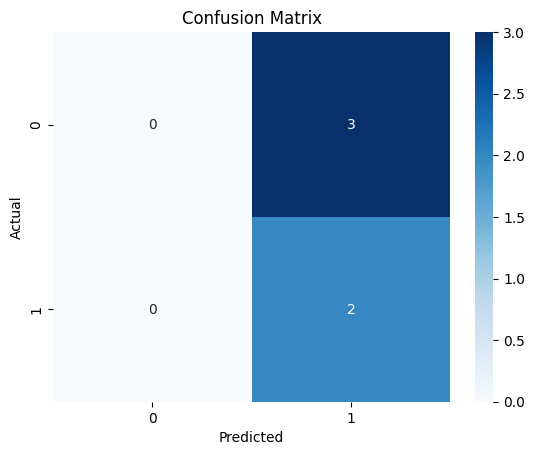

In [17]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
